# Test 2 - Model without reasoning _vs_ model with reasoning _vs_ models with reasoning every $x$ turns

In [22]:
! tar czf Testing.tar *

In [1]:
! nvidia-smi

Tue Sep  9 22:29:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0 Off |                  Off |
| 42%   53C    P8             32W /  450W |      15MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import time
import textworld
import textworld.gym
import numpy as np
import re
import os
from glob import glob
from typing import Mapping, Any
import pickle
import random
import matplotlib.pyplot as plt

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
import torch
import accelerate
torch.set_default_device('cuda')
torch.cuda.device("cuda")
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('high')

In [3]:
model_name = "Qwen/Qwen3-4B"

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype="auto",
    device_map="auto"
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [5]:
print(model.hf_device_map)

{'': 0}


## Play function

In [5]:
def play(agent, path, max_steps=100, n_episodes=10, verbose=True):
    torch.manual_seed(46)  # For reproducibility when using action sampling.

    infos_to_request = agent.infos_to_request
    infos_to_request.max_score = True  # Needed to normalize the scores.

    gamefiles = [path]
    if os.path.isdir(path):
        gamefiles = glob(os.path.join(path, "*.z8"))

    env_id = textworld.gym.register_games(gamefiles,
                                          request_infos=infos_to_request,
                                          max_episode_steps=max_steps)
    env = textworld.gym.make(env_id)  # Create a Gym environment to play the text game.
    if verbose:
        if os.path.isdir(path):
            print(os.path.dirname(path), end="")
        else:
            print(os.path.basename(path), end="")

    # Collect some statistics
    avg_moves, avg_scores, avg_norm_scores = [], [], []
    moves_scores_times_list = []
    
    for no_episode in range(n_episodes):
        episode_start = time.process_time()
        obs, infos = env.reset()  # Start new episode.

        score = 0
        done = False
        nb_moves = 0
        moves_scores_times = [(0, 0, 0)] # starting point
        
        while not done:
            command = agent.act(obs, score, done, infos)
            timestamp = time.process_time()
            obs, score, done, infos = env.step(command)
            nb_moves += 1
            moves_scores_times.append((nb_moves, score, timestamp - episode_start))

        agent.act(obs, score, done, infos)  # Let the agent know the game is done.
        moves_scores_times_list.append(moves_scores_times)

        if verbose:
            print(".", end="")
        avg_moves.append(nb_moves)
        avg_scores.append(score)
        avg_norm_scores.append(score / infos["max_score"])

    env.close()
    if verbose:
        if os.path.isdir(path):
            msg = "  \tavg. steps: {:5.1f}; avg. normalized score: {:4.1f} / {}."
            print(msg.format(np.mean(avg_moves), np.mean(avg_norm_scores), 1))
            if len(avg_moves) > 1:
                print(f"Detailed steps: {avg_moves}\t Detailed normalized scores: {avg_norm_scores}")
        else:
            msg = "  \tavg. steps: {:5.1f}; avg. score: {:4.1f} / {}."
            print(msg.format(np.mean(avg_moves), np.mean(avg_scores), infos["max_score"]))
            if len(avg_moves) > 1:
                print(f"Detailed steps: {avg_moves}\t Detailed scores: {avg_scores}")
        return moves_scores_times_list

## Agents

In [6]:
class LLMAgent(textworld.gym.Agent):
    """LLM from HuggingFace that acts as an agent."""
    model = None
    tokenizer = None
    context = ""

    token_think = "/think"
    token_nothink = "/no_think"
    id_token_open_think = None # <think> . TODO find it
    id_token_close_think = 151668 # </think>
    token_system = "<|im_start|>system\n"
    token_endofturn = "<|im_end|>\n"
    token_user = "<|im_start|>user\n"
    token_assistant = "<|im_start|>assistant\n"
    system_prompt = """
You are an assistant playing a textual game.
The user gives you information on the environment and you reply exclusively in the form \"verb noun\", like \"open box\" or \"take key\".
/no_think
"""
    first_move = False
    
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.initialize_context()

    def initialize_context(self):
        self.context = self.token_system + self.system_prompt + self.token_endofturn
        self.first_move = True

    @property
    def infos_to_request(self) -> textworld.EnvInfos:
        return textworld.EnvInfos(admissible_commands=True)

    def act(self, obs: str, score: int, done: bool, infos: Mapping[str, Any]) -> str:

        if done:
            self.initialize_context() # resets context
            return ":)"
            
        if self.first_move:
            self.first_move = False
            return "help"
        
        try:
            self.context += self.token_user + obs + self.token_endofturn
            self.context += self.token_assistant # induces model to generate answer
            
            input_ids = self.tokenizer.encode(
                self.context,
                return_tensors = "pt")
            
            generated_ids = self.model.generate(
                input_ids.to("cuda"),
                max_new_tokens = 100,
                eos_token_id = self.tokenizer.eos_token_id
                )
            output_ids = generated_ids[0][len(input_ids[0]):].tolist() 
            
            # parsing thinking content
            try:
                # index finding </think>
                index = len(output_ids) - output_ids[::-1].index(self.id_token_close_think)
            except ValueError:
                index = 0
            response = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")
            
            self.context += response + self.token_endofturn

            if len(response.split()) <= 10:
                command = response
            else: # more than 10 words, output is surely wrong
                command = "look"
            return command
            
        except KeyboardInterrupt:
            pass  # Try stopping the game prematurely.

In [7]:
class LLMAgentSelfEvaluate(LLMAgent):
    """LLM from HuggingFace that acts as an agent. It self-evaluates its status and moves."""

    selfeval_turn_counter = 0
    selfeval_turns = 5
    shorter_reasoning = False
    handheld = True
    verbose = False
    reads_own_reasoning = False

    def __init__(self, model, tokenizer, selfeval_turns = 5, handheld = True, verbose = False, reads_own_reasoning = False):
        """Initialization function.
        selfeval_turns: how many turns should pass between a self-evaluation and the next one.
        handheld: if this is set to True there are a few simple changes in the function that make it easier for the LLM to understand and correct its course
        reads_own_reasoning: if the model's reasoning during the self-evaluation turns should be included in the context too, or only its final action
        """
        super().__init__(model, tokenizer)
        if selfeval_turns == 0:
            selfeval_turns = -1 # actual default value for deactivating self-evaluation
        elif 1 <= selfeval_turns <= 4: # model will think a lot so we need to take care of the context. TODO
            self.shorter_reasoning = True
        self.selfeval_turns = selfeval_turns
        self.handheld = handheld
        self.verbose = verbose
        self.reads_own_reasoning = reads_own_reasoning

    def initialize_context(self):
        super().initialize_context()
        self.selfeval_turn_counter = 0

    def generate_response(self, think=False):
        if think:
            max_new_tokens = 20000 # allow reasoning models to be talkative
        else:
            max_new_tokens = 20 # reduce generation almost to a minimum
        
        input_ids = self.tokenizer.encode(
                self.context,
                return_tensors = "pt")
        try:
            generated_ids = self.model.generate(
                input_ids.to("cuda"),
                max_new_tokens = max_new_tokens,
                eos_token_id = self.tokenizer.eos_token_id
                )
            output_ids = generated_ids[0][len(input_ids[0]):].tolist()
        except:
            return "help" # model is in distress :)

        if len(output_ids) >= max_new_tokens: # reached cap -- let's help the model a bit
            substitute_command = random.choice(["help", "look"])
            if think:
                return ("", substitute_command)
            else:
                return substitute_command
        
        try:
            # index finding </think>
            index = len(output_ids) - output_ids[::-1].index(self.id_token_close_think)
        except ValueError:
            index = 0
        if think:
            thinking_response = tokenizer.decode(output_ids[:index], skip_special_tokens=True) \
            .replace("/think", "") \
            .replace("/no_think", "") \
            .strip("\n")
            response = tokenizer.decode(output_ids[(index+1):], skip_special_tokens=True) \
            .replace("<think>", "") \
            .replace("</think>", "") \
            .replace("/think", "") \
            .replace("/no_think", "") \
            .strip("\n")
            return (thinking_response, response)
        else:
            response = tokenizer.decode(output_ids[index:], skip_special_tokens=True) \
            .replace("<think>", "") \
            .replace("</think>", "") \
            .replace("/think", "") \
            .replace("/no_think", "") \
            .strip("\n")
            return response

    def act(self, obs: str, score: int, done: bool, infos: Mapping[str, Any]) -> str:
        if done:
            self.initialize_context() # resets context
            return ":)"
        
        if self.selfeval_turn_counter == self.selfeval_turns: # time for self-evaluation
            self.selfeval_turn_counter = 0 # reset counter
            return self.self_evaluation(obs)
            
        try:
            self.context += self.token_user + obs + self.token_endofturn
            self.context += self.token_assistant # induces model to generate answer

            if self.first_move and self.handheld:
                self.first_move = False
                command = "help"
            else:
                response = self.generate_response()
                if len(response.split()) <= 10 or not self.handheld:
                    command = response
                else: # more than 10 words, output is surely wrong
                    command = "look"
            
            self.context += command + self.token_endofturn

            
            if self.verbose:
                print("GAME ++++++++++++++++++++++++++++++++++++++++++++++++++")
                print(obs)
                print("AGENT -------------------------------------------------")
                print(command)

            self.selfeval_turn_counter += 1
            return command
            
        except KeyboardInterrupt:
            pass  # Try stopping the game prematurely.

    def self_evaluation(self, obs) -> str :
        if self.shorter_reasoning:
            self_evaluation_prompt = """
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.
"""
        else:
            self_evaluation_prompt = """
Do you think you're making the right actions in the game? Do you think you're close to reaching the original goal? Think about it. 
"""
        self.context += self.token_user + obs + self_evaluation_prompt + self.token_think + self.token_endofturn 
        self.context += self.token_assistant # induce thinking
        
        (thinking_response, response) = self.generate_response(think=True)
        if self.verbose:
            print("GAME ++++++++++++++++++++++++++++++++++++++++++++++++++")
            print(obs + self_evaluation_prompt + self.token_think)
            print("SELF-EVALUATION: +-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-")
            print(thinking_response + response + self.token_nothink)

        if self.reads_own_reasoning:
            self.context += thinking_response + response + self.token_nothink + self.token_endofturn
        else:
            self.context += response + self.token_nothink + self.token_endofturn

        if len(response.split()) <= 10 or not self.handheld:
            command = response
        else: # more than 10 words, output is surely wrong
            command = "look"
        self.selfeval_turn_counter += 1
        return command
        

## Game generation

In [3]:
max_steps = 100
n_episodes = 10

In [4]:
# 1 to 10
seeds = range(1,11)

In [ ]:
# 0 to 9
seeds = range(10)

In [ ]:
# polietilene
seeds = [6, 10, 20, 45, 46, 89, 79010123, 1179382318]

In [ ]:
!tw-make tw-simple --rewards dense --goal detailed --seed 0 --test --silent -f --output games/test-seed0.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 1 --test --silent -f --output games/test-seed1.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 2 --test --silent -f --output games/test-seed2.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 3 --test --silent -f --output games/test-seed3.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 4 --test --silent -f --output games/test-seed4.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 5 --test --silent -f --output games/test-seed5.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 6 --test --silent -f --output games/test-seed6.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 7 --test --silent -f --output games/test-seed7.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 8 --test --silent -f --output games/test-seed8.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 9 --test --silent -f --output games/test-seed9.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 10 --test --silent -f --output games/test-seed10.z8

## Game running

In [10]:
def play_seeds(mode, verbose = False):
    if mode == "nothink" or mode == -1:
        selfeval_turns = -1
        mode_name = "nothink"
    elif mode == "fullthink" or mode == 1:
        selfeval_turns = 1
        mode_name = "fullthink"
    elif type(mode) is not type(1):
        return "Error! Mode not recognized."
    else:
        selfeval_turns = mode
        mode_name = f"{mode}-think"
        
    for seed in seeds:
        results = play(LLMAgentSelfEvaluate(model, tokenizer, selfeval_turns = selfeval_turns, handheld=False, verbose=verbose),
                f"./games/test-seed{seed}.z8", max_steps=max_steps, n_episodes=n_episodes)
        with open(f'./Testing 2/{mode_name}_seed{seed}.pickle', 'wb') as f:
            pickle.dump(results, f)
            print("Data pickled.")
            f.close()

In [12]:
play_seeds("nothink")

test-seed1.z8..........  	avg. steps:  89.6; avg. score:  7.2 / 8.
Detailed steps: [100, 100, 100, 100, 100, 47, 100, 100, 49, 100]	 Detailed scores: [7, 7, 7, 7, 7, 8, 7, 7, 8, 7]
Data pickled.
test-seed2.z8..........  	avg. steps: 100.0; avg. score:  8.0 / 10.
Detailed steps: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]	 Detailed scores: [9, 9, 9, 9, 9, 4, 9, 9, 9, 4]
Data pickled.
test-seed3.z8..........  	avg. steps:   8.0; avg. score:  7.0 / 7.
Detailed steps: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]	 Detailed scores: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
Data pickled.
test-seed4.z8..........  	avg. steps: 100.0; avg. score:  5.5 / 10.
Detailed steps: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]	 Detailed scores: [2, 2, 2, 9, 2, 9, 9, 9, 2, 9]
Data pickled.
test-seed5.z8..........  	avg. steps: 100.0; avg. score:  4.0 / 7.
Detailed steps: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]	 Detailed scores: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Data pickled.
test-seed6.z8..........  	avg. step

In [11]:
play_seeds("fullthink", verbose=False)

test-seed1.z8....

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You go west.


Your score has just gone up by one point.

>                                                                                                                                -= Bedroom =-5/9
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to 'You go west.


Your score has just gone up by one point.

>                                                                                                                                -= Bedroom '.
  warnings.warn(msg, TruncatedInputActionWarning)
/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You go south.


Your score has just gone up

......  	avg. steps:  18.0; avg. score:  8.0 / 8.
Detailed steps: [15, 10, 18, 27, 30, 11, 15, 22, 11, 21]	 Detailed scores: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Data pickled.
test-seed2.z8.

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You move east.


Your score has just gone up by one point.

>                                                                                                                                -= Kitchen =-5/6
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to 'You move east.


Your score has just gone up by one point.

>                                                                                                                                -= Kitche'.
  warnings.warn(msg, TruncatedInputActionWarning)
/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You can't see any such thing.

>         

.

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You go south.


Your score has just gone up by one point.

>                                                                                                                                -= Garden =-8/9
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to 'You go south.


Your score has just gone up by one point.

>                                                                                                                                -= Garden '.
  warnings.warn(msg, TruncatedInputActionWarning)


........  	avg. steps:  24.4; avg. score:  9.4 / 10.
Detailed steps: [18, 100, 18, 17, 12, 21, 12, 22, 12, 12]	 Detailed scores: [10, 4, 10, 10, 10, 10, 10, 10, 10, 10]
Data pickled.
test-seed3.z8...

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You go east.


Your score has just gone up by one point.

>                                                                                                                                -= Kitchen =-1/6
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to 'You go east.


Your score has just gone up by one point.

>                                                                                                                                -= Kitchen '.
  warnings.warn(msg, TruncatedInputActionWarning)
/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You must name something more substantial.



.

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You go east.


Your score has just gone up by one point.

>                                                                                                                                -= Kitchen =-2/6
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to 'You go east.


Your score has just gone up by one point.

>                                                                                                                                -= Kitchen '.
  warnings.warn(msg, TruncatedInputActionWarning)
/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You go east.


Your score has just gone up 

......  	avg. steps:  20.3; avg. score:  6.7 / 7.
Detailed steps: [8, 8, 9, 25, 100, 12, 8, 8, 13, 12]	 Detailed scores: [7, 7, 7, 7, 4, 7, 7, 7, 7, 7]
Data pickled.
test-seed4.z8..........  	avg. steps:  17.6; avg. score: 10.0 / 10.
Detailed steps: [15, 19, 12, 15, 16, 21, 21, 22, 17, 18]	 Detailed scores: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Data pickled.
test-seed5.z8

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You can't see any such thing.

>                                                                                                                                -= Bedroom =-4/7
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to 'You can't see any such thing.

>                                                                                                                                -= Bedroom =-4/7
Do you think you're m'.
  warnings.warn(msg, TruncatedInputActionWarning)


.

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You can't see any such thing.

>                                                                                                                                -= Bedroom =-4/14
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to 'You can't see any such thing.

>                                                                                                                                -= Bedroom =-4/14
Do you think you're '.
  warnings.warn(msg, TruncatedInputActionWarning)


.

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You can't see any such thing.

>                                                                                                                                -= Bedroom =-3/12
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to 'You can't see any such thing.

>                                                                                                                                -= Bedroom =-3/12
Do you think you're '.
  warnings.warn(msg, TruncatedInputActionWarning)
/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You have to open the wooden door first.


>                          

.

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action '(with wooden door)
The wooden door is fixed in place.


>                                                                                                                                -= Bedroom =-1/15
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to '(with wooden door)
The wooden door is fixed in place.


>                                                                                                                                -= Bedroom =-'.
  warnings.warn(msg, TruncatedInputActionWarning)


.

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You rest the kiwi on the stove.



Your score has just gone up by one point.

>                                                                                                                                -= Kitchen =-7/16
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to 'You rest the kiwi on the stove.



Your score has just gone up by one point.

>                                                                                                                       '.
  warnings.warn(msg, TruncatedInputActionWarning)


......  	avg. steps:  33.1; avg. score:  6.7 / 7.
Detailed steps: [29, 100, 53, 29, 24, 16, 17, 18, 16, 29]	 Detailed scores: [7, 4, 7, 7, 7, 7, 7, 7, 7, 7]
Data pickled.
test-seed6.z8.

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You put the carrot on the stove.



Your score has just gone up by one point.

>                                                                                                                                -= Kitchen =-10/18
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to 'You put the carrot on the stove.



Your score has just gone up by one point.

>                                                                                                                      '.
  warnings.warn(msg, TruncatedInputActionWarning)


.........  	avg. steps:  33.0; avg. score:  9.1 / 10.
Detailed steps: [46, 28, 19, 21, 22, 37, 18, 21, 100, 18]	 Detailed scores: [10, 10, 10, 10, 10, 10, 10, 10, 1, 10]
Data pickled.
test-seed7.z8..

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You open the wooden door.


Your score has just gone up by one point.

>                                                                                                                                -= Bedroom =-4/8
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to 'You open the wooden door.


Your score has just gone up by one point.

>                                                                                                                              '.
  warnings.warn(msg, TruncatedInputActionWarning)
/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You go east.


Your score has 

..

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You unlock the wooden door with the old key.


Your score has just gone up by one point.

>                                                                                                                                -= Bedroom =-3/11
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to 'You unlock the wooden door with the old key.


Your score has just gone up by one point.

>                                                                                                           '.
  warnings.warn(msg, TruncatedInputActionWarning)
/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'Okay, I th

.

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You open the wooden door.


Your score has just gone up by one point.

>                                                                                                                                -= Bedroom =-4/10
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to 'You open the wooden door.


Your score has just gone up by one point.

>                                                                                                                              '.
  warnings.warn(msg, TruncatedInputActionWarning)
/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'I beg your pardon?

>        

..

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You open the fridge.



Your score has just gone up by one point.

>                                                                                                                                -= Bedroom =-5/12
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to 'You open the fridge.



Your score has just gone up by one point.

>                                                                                                                                -='.
  warnings.warn(msg, TruncatedInputActionWarning)
/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You can't see any such thing.  



...  	avg. steps:  21.5; avg. score:  7.0 / 7.
Detailed steps: [10, 14, 28, 16, 21, 23, 21, 45, 24, 13]	 Detailed scores: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
Data pickled.
test-seed8.z8....

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You venture east.


Your score has just gone up by one point.

>                                                                                                                                -= Kitchen =-5/6
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to 'You venture east.


Your score has just gone up by one point.

>                                                                                                                                -= Kit'.
  warnings.warn(msg, TruncatedInputActionWarning)


...

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You open the wooden door.


Your score has just gone up by one point.

>                                                                                                                                -= Bedroom =-4/11
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to 'You open the wooden door.


Your score has just gone up by one point.

>                                                                                                                              '.
  warnings.warn(msg, TruncatedInputActionWarning)


...  	avg. steps:  20.2; avg. score: 10.0 / 10.
Detailed steps: [12, 16, 20, 25, 34, 15, 21, 30, 15, 14]	 Detailed scores: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Data pickled.
test-seed9.z8

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'You open the wooden door.


Your score has just gone up by one point.

>                                                                                                                                -= Bedroom =-4/7
Do you think you're making the right actions in the game? Think about it briefly, and then say your next action in the same way as before.' was truncated to 'You open the wooden door.


Your score has just gone up by one point.

>                                                                                                                              '.
  warnings.warn(msg, TruncatedInputActionWarning)


........

/usr/local/lib/python3.12/site-packages/jericho/jericho.py:484: TruncatedInputActionWarning: Once converted to bytes, actions should have less than 198 characters. Action 'Thought: The user is repeatedly trying to unlock the door but is facing a system error. The correct action is to use the old key on the wooden door, but the system doesn't recognize the command. The next step is to try a different phrasing, such as "use key on door" or "unlock door". However, based on the game's structure, the correct verb-noun pair is "unlock door".  

**Next action:**  
unlock door' was truncated to 'Thought: The user is repeatedly trying to unlock the door but is facing a system error. The correct action is to use the old key on the wooden door, but the system doesn't recognize the command. The'.
  warnings.warn(msg, TruncatedInputActionWarning)


..  	avg. steps:  14.0; avg. score:  7.0 / 7.
Detailed steps: [18, 25, 8, 12, 13, 13, 10, 11, 21, 9]	 Detailed scores: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
Data pickled.
test-seed10.z8..........  	avg. steps:  17.0; avg. score:  7.0 / 7.
Detailed steps: [14, 31, 17, 14, 16, 13, 13, 16, 12, 24]	 Detailed scores: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
Data pickled.


In [12]:
play_seeds(5)

test-seed1.z8..........  	avg. steps:  21.8; avg. score:  7.9 / 8.
Detailed steps: [11, 11, 11, 11, 100, 30, 11, 11, 11, 11]	 Detailed scores: [8, 8, 8, 8, 7, 8, 8, 8, 8, 8]
Data pickled.
test-seed2.z8..........  	avg. steps:  21.3; avg. score: 10.0 / 10.
Detailed steps: [16, 18, 16, 37, 22, 21, 21, 18, 16, 28]	 Detailed scores: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Data pickled.
test-seed3.z8..........  	avg. steps:   8.0; avg. score:  7.0 / 7.
Detailed steps: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]	 Detailed scores: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
Data pickled.
test-seed4.z8..........  	avg. steps:  74.8; avg. score:  4.4 / 10.
Detailed steps: [100, 16, 100, 100, 16, 16, 100, 100, 100, 100]	 Detailed scores: [2, 10, 2, 2, 10, 10, 2, 2, 2, 2]
Data pickled.
test-seed5.z8..........  	avg. steps:  20.2; avg. score:  6.7 / 7.
Detailed steps: [10, 10, 10, 11, 10, 10, 10, 100, 21, 10]	 Detailed scores: [7, 7, 7, 7, 7, 7, 7, 4, 7, 7]
Data pickled.
test-seed6.z8..........  	avg. steps:  12.4; avg. s

In [11]:
play_seeds(10)

test-seed1.z8..........  	avg. steps:  11.0; avg. score:  8.0 / 8.
Detailed steps: [11, 11, 11, 11, 11, 11, 11, 11, 11, 11]	 Detailed scores: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Data pickled.
test-seed2.z8..........  	avg. steps:  37.5; avg. score: 10.0 / 10.
Detailed steps: [23, 41, 31, 42, 31, 31, 22, 72, 41, 41]	 Detailed scores: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Data pickled.
test-seed3.z8..........  	avg. steps:   8.0; avg. score:  7.0 / 7.
Detailed steps: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]	 Detailed scores: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
Data pickled.
test-seed4.z8..........  	avg. steps:  80.9; avg. score:  6.7 / 10.
Detailed steps: [100, 56, 71, 100, 47, 100, 100, 35, 100, 100]	 Detailed scores: [3, 10, 10, 2, 10, 2, 9, 10, 2, 9]
Data pickled.
test-seed5.z8..........  	avg. steps:  30.7; avg. score:  7.0 / 7.
Detailed steps: [26, 37, 27, 21, 66, 16, 21, 16, 61, 16]	 Detailed scores: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
Data pickled.
test-seed6.z8..........  	avg. steps:  12.0; avg. sco

# Visualization

In [8]:
results_nothink = []
results_fullthink = []
results_5think = []
results_10think = []

for seed in seeds:
    with open(f'Testing 2/nothink_seed{seed}.pickle', 'rb') as f:
        results_nothink.append(pickle.load(f))
        f.close()
    with open(f'Testing 2/fullthink_seed{seed}.pickle', 'rb') as f:
        results_fullthink.append(pickle.load(f))
        f.close()
    with open(f'Testing 2/5-think_seed{seed}.pickle', 'rb') as f:
        results_5think.append(pickle.load(f))
        f.close()
    with open(f'Testing 2/10-think_seed{seed}.pickle', 'rb') as f:
        results_10think.append(pickle.load(f))
        f.close()

In [170]:
from scipy.stats import bootstrap

In [ ]:
max_scores = [8, 10, 7, 10, 7, 10, 7, 10, 7, 7]

avg_scores_nothink = []
std_nothink = []
bs_nothink = []
avg_scores_fullthink = []
std_fullthink = []
bs_fullthink = []
avg_scores_5think = []
std_5think = []
bs_5think = []
avg_scores_10think = []
std_10think = []
bs_10think = []
results_scores_std = [(results_nothink, avg_scores_nothink, std_nothink, bs_nothink),
                (results_fullthink, avg_scores_fullthink, std_fullthink, bs_fullthink),
                (results_5think, avg_scores_5think, std_5think, bs_5think),
                (results_10think, avg_scores_10think, std_10think, bs_10think)]

for model in results_scores_std:
    results, avg_scores, std, bs = model
    for seed in seeds:
        scores_of_final_steps = []
        runs = results[seed-1]
        for run in runs:
            scores_of_final_steps.append(run[-1][1]) # 2nd parameter (aka score) of last step
        avg_scores.append(np.mean(scores_of_final_steps) / max_scores[seed-1])
        std.append(np.std(scores_of_final_steps) / max_scores[seed-1])
        bootstrap_results = bootstrap(data=(np.array(scores_of_final_steps)/max_scores[seed-1],), 
                              statistic=np.mean,
                              method="basic",
                              n_resamples=1000,
                              confidence_level=0.9)
        bs.append((bootstrap_results.confidence_interval.high, bootstrap_results.confidence_interval.low))        
        

In [10]:
print(avg_scores_nothink)
print(std_nothink)

[np.float64(0.9), np.float64(0.8), np.float64(1.0), np.float64(0.55), np.float64(0.5714285714285714), np.float64(0.9099999999999999), np.float64(1.0), np.float64(0.93), np.float64(1.0), np.float64(1.0)]
[np.float64(0.39999999999999997), np.float64(2.0), np.float64(0.0), np.float64(3.5), np.float64(0.0), np.float64(0.3), np.float64(0.0), np.float64(0.45825756949558394), np.float64(0.0), np.float64(0.0)]


In [13]:
avg_times_nothink = []
std_times_nothink = []
avg_times_fullthink = []
std_times_fullthink = []
avg_times_5think = []
std_times_5think = []
avg_times_10think = []
std_times_10think = []
results_times_std = [(results_nothink, avg_times_nothink, std_times_nothink),
                (results_fullthink, avg_times_fullthink, std_times_fullthink),
                (results_5think, avg_times_5think, std_times_5think),
                (results_10think, avg_times_10think, std_times_10think)]

for model in results_times_std:
    results, avg_times, std_times = model
    for seed in seeds:
        times_of_final_steps = []
        runs = results[seed-1]
        for run in runs:
            times_of_final_steps.append(run[-1][2]) # 3rd parameter (aka time) of last step
        avg_times.append(np.mean(times_of_final_steps))
        std_times.append(np.std(times_of_final_steps))

In [14]:
print(avg_times_nothink)
print(std_times_nothink)

[np.float64(28.4300772543), np.float64(31.763657541000008), np.float64(1.2399932578999937), np.float64(49.19406693649997), np.float64(26.704977851600052), np.float64(41.891900372500004), np.float64(1.5536869351000178), np.float64(33.5945569876), np.float64(1.672821979199989), np.float64(1.3906766267999955)]
[np.float64(7.271113320052689), np.float64(4.086677958081168), np.float64(0.004464711384229425), np.float64(9.259104943745719), np.float64(2.4320823159558485), np.float64(13.269587689239584), np.float64(0.08873939433606111), np.float64(19.99668164072732), np.float64(0.07812321248657635), np.float64(0.1693432629715951)]


In [29]:
figsize=(7,7)

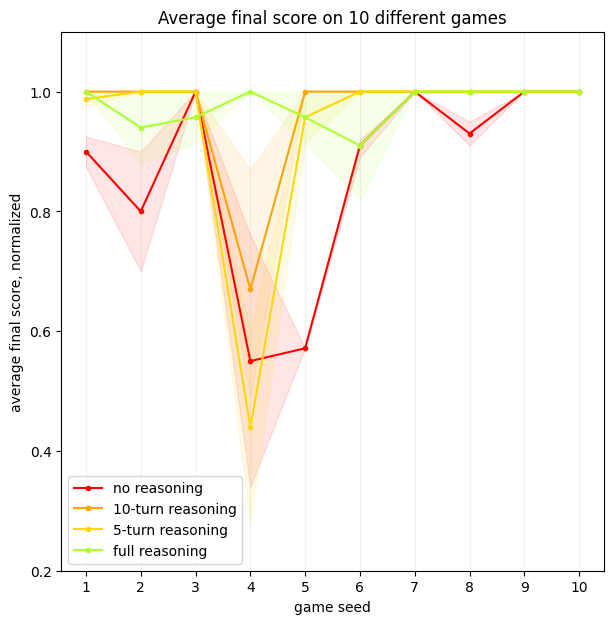

In [190]:
x = list(seeds) # converting into a list just to be sure, maybe an iterator doesn't work here

fig, ax = plt.subplots(figsize=figsize)

ax.plot(x, avg_scores_nothink, label="no reasoning", marker=".", linestyle="-", color="red")
ax.plot(x, avg_scores_10think, label="10-turn reasoning", marker=".", linestyle="-", color="orange")
ax.plot(x, avg_scores_5think, label="5-turn reasoning", marker=".", linestyle="-", color="gold")
ax.plot(x, avg_scores_fullthink, label="full reasoning", marker=".", linestyle="-", color="greenyellow")

# ax.fill_between(x,
#                 np.clip([np.array(avg_scores_nothink) + np.array(std_nothink)], 0, 1),
#                 np.clip(np.array(avg_scores_nothink) - np.array(std_nothink), 0, 1),
#                 alpha=0.05, color="red")
# ax.fill_between(x,
#                 np.clip(np.array(avg_scores_10think) + np.array(std_10think), 0, 1),
#                 np.clip(np.array(avg_scores_10think) - np.array(std_10think), 0, 1),
#                 alpha=0.05, color="orange")
# ax.fill_between(x,
#                 np.clip(np.array(avg_scores_5think) + np.array(std_5think), 0, 1),
#                 np.clip(np.array(avg_scores_5think) - np.array(std_5think), 0, 1),
#                 alpha=0.05, color="gold")
# ax.fill_between(x,
#                 np.clip(np.array(avg_scores_fullthink) + np.array(std_fullthink), 0, 1),
#                 np.clip(np.array(avg_scores_fullthink) - np.array(std_fullthink), 0, 1),
#                 alpha=0.05, color="greenyellow")

ax.fill_between(x,
                np.clip([i[0] for i in bs_nothink], 0, 1),
                np.clip([i[1] for i in bs_nothink], 0, 1),
                alpha=0.1, color="red")
ax.fill_between(x,
                np.clip([i[0] for i in bs_10think], 0, 1),
                np.clip([i[1] for i in bs_10think], 0, 1),
                alpha=0.1, color="orange")
ax.fill_between(x,
                np.clip([i[0] for i in bs_5think], 0, 1),
                np.clip([i[1] for i in bs_5think], 0, 1),
                alpha=0.1, color="gold")
ax.fill_between(x,
                np.clip([i[0] for i in bs_fullthink], 0, 1),
                np.clip([i[1] for i in bs_fullthink], 0, 1),
                alpha=0.1, color="greenyellow")


ax.set_title("Average final score on 10 different games")
ax.set_xlabel('game seed')
ax.set_ylabel('average final score, normalized')

gridlines = np.arange(x[0], x[-1]+1, 1)
ax.set_xticks(gridlines)
ax.grid(axis="x", alpha=0.2)

ax.set_ylim(0.2, 1.1)

ax.legend()
plt.show()

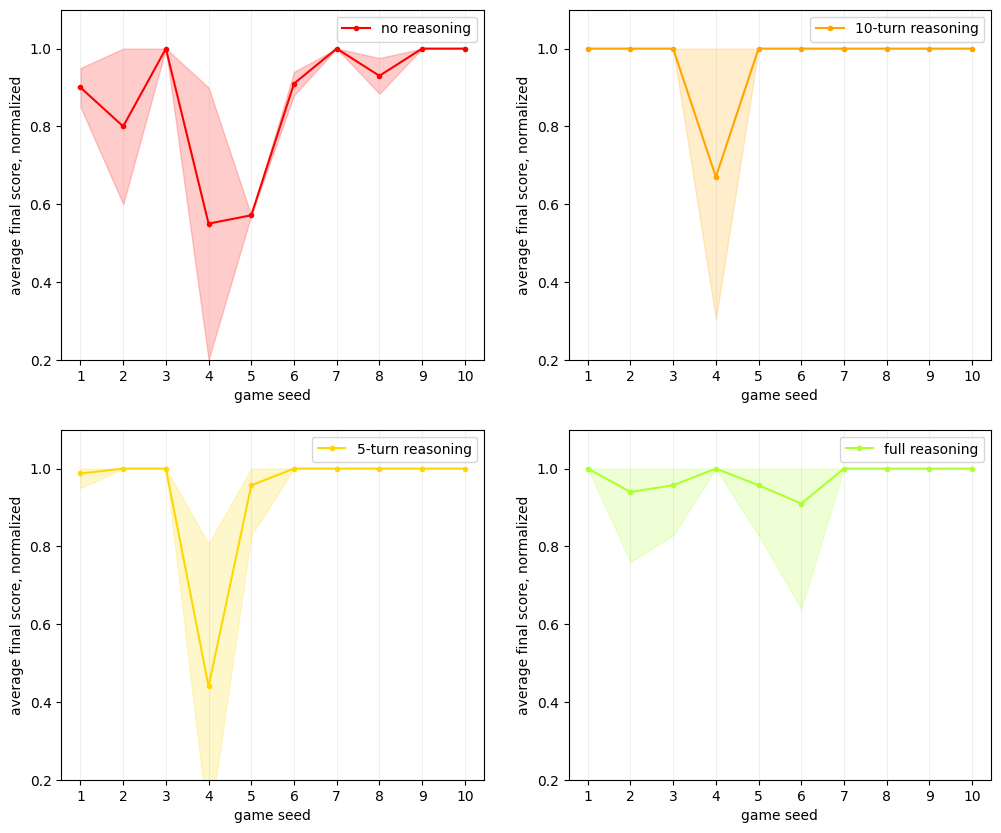

In [166]:
x = list(seeds) # converting into a list just to be sure, maybe an iterator doesn't work here

fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(2, 2, figsize=(12,10))

ax1.plot(x, avg_scores_nothink, label="no reasoning", marker=".", linestyle="-", color="red")
ax2.plot(x, avg_scores_10think, label="10-turn reasoning", marker=".", linestyle="-", color="orange")
ax3.plot(x, avg_scores_5think, label="5-turn reasoning", marker=".", linestyle="-", color="gold")
ax4.plot(x, avg_scores_fullthink, label="full reasoning", marker=".", linestyle="-", color="greenyellow")

ax1.fill_between(x, np.clip(np.array(avg_scores_nothink) + np.array(std_nothink), 0, 1), np.clip(np.array(avg_scores_nothink) - np.array(std_nothink), 0, 1), alpha=0.2, color="red")
ax2.fill_between(x, np.clip(np.array(avg_scores_10think) + np.array(std_10think), 0, 1), np.clip(np.array(avg_scores_10think) - np.array(std_10think), 0, 1), alpha=0.2, color="orange")
ax3.fill_between(x, np.clip(np.array(avg_scores_5think) + np.array(std_5think), 0, 1), np.clip(np.array(avg_scores_5think) - np.array(std_5think), 0, 1), alpha=0.2, color="gold")
ax4.fill_between(x, np.clip(np.array(avg_scores_fullthink) + np.array(std_fullthink), 0, 1), np.clip(np.array(avg_scores_fullthink) - np.array(std_fullthink), 0, 1), alpha=0.2, color="greenyellow")

gridlines = np.arange(x[0], x[-1]+1, 1)
for ax in (ax1, ax2, ax3, ax4):
    
    ax.set_xlabel('game seed')
    ax.set_ylabel('average final score, normalized')

    ax.set_xticks(gridlines)
    ax.grid(axis="x", alpha=0.2)
    ax.set_ylim(0.2, 1.1)

    ax.legend()

#fig.suptitle("Average final score on 10 different games")


plt.show()

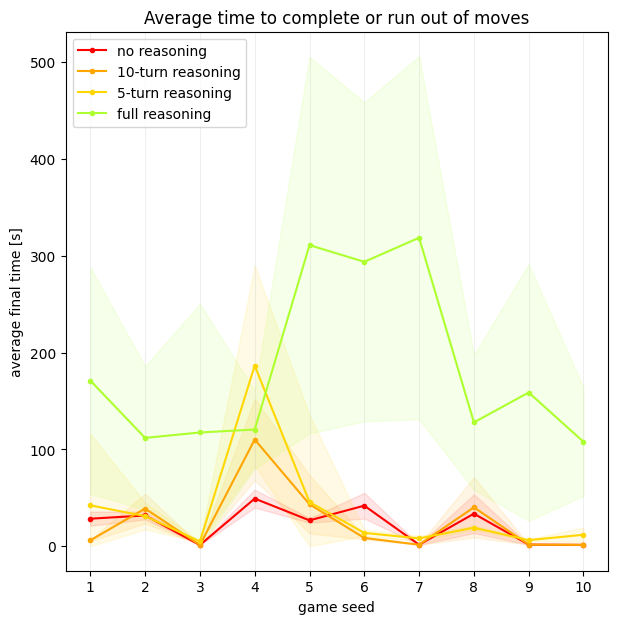

In [56]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(x, avg_times_nothink, label="no reasoning", marker=".", linestyle="-", color="red")
ax.plot(x, avg_times_10think, label="10-turn reasoning", marker=".", linestyle="-", color="orange")
ax.plot(x, avg_times_5think, label="5-turn reasoning", marker=".", linestyle="-", color="gold")
ax.plot(x, avg_times_fullthink, label="full reasoning", marker=".", linestyle="-", color="greenyellow")
ax.fill_between(x, np.array(avg_times_nothink) + np.array(std_times_nothink), np.clip(np.array(avg_times_nothink) - np.array(std_times_nothink), 0, None), alpha=0.1, color="red")
ax.fill_between(x, np.array(avg_times_10think) + np.array(std_times_10think), np.clip(np.array(avg_times_10think) - np.array(std_times_10think), 0, None), alpha=0.1, color="orange")
ax.fill_between(x, np.array(avg_times_5think) + np.array(std_times_5think), np.clip(np.array(avg_times_5think) - np.array(std_times_5think), 0, None), alpha=0.1, color="gold")
ax.fill_between(x, np.array(avg_times_fullthink) + np.array(std_times_fullthink), np.clip(np.array(avg_times_fullthink) - np.array(std_times_fullthink), 0, None), alpha=0.1, color="greenyellow")

ax.set_title("Average time to complete or run out of moves")
ax.set_xlabel('game seed')
ax.set_ylabel('average final time [s]')

gridlines = np.arange(x[0], x[-1]+1, 1)
ax.set_xticks(gridlines)
ax.grid(axis="x", alpha=0.2)

ax.legend()
plt.show()

# Bundles of tries

In [ ]:
# better to use a seed with 10 total score, for clarity
bundle_seed = 11
!tw-make tw-simple --rewards dense --goal detailed --seed 11 --test --silent -f --output games/test-seed11.z8

In [ ]:
results = play(LLMAgentSelfEvaluate(model, tokenizer, selfeval_turns = -1, handheld=False, verbose=False),
        f"./games/test-seed{bundle_seed}.z8", max_steps=max_steps, n_episodes=n_episodes)

with open(f'./Testing 2/nothink_seed{seed}.pickle', 'wb') as f:
    pickle.dump(results, f)
    print("Data pickled.")
    f.close()

In [ ]:
results = play(LLMAgentSelfEvaluate(model, tokenizer, selfeval_turns = 10, handheld=False, verbose=False),
        f"./games/test-seed{bundle_seed}.z8", max_steps=max_steps, n_episodes=n_episodes)

with open(f'./Testing 2/10-think_seed{seed}.pickle', 'wb') as f:
    pickle.dump(results, f)
    print("Data pickled.")
    f.close()

In [194]:
# temporary override
bundle_seed = 4
max_score_bundle = 10

In [195]:
cum_score_index = 1 # (step number, cumulative score, timestamp from beginning of episode)

bundle_nothink = []
bundle_10think = []
cum_scores_nothink = []
cum_scores_10think = []

with open(f'Testing 2/nothink_seed{bundle_seed}.pickle', 'rb') as f:
        bundle_nothink = pickle.load(f)
        f.close()
with open(f'Testing 2/10-think_seed{bundle_seed}.pickle', 'rb') as f:
        bundle_10think = pickle.load(f)
        f.close()

bundles_cum_scores = [(bundle_nothink, cum_scores_nothink), (bundle_10think, cum_scores_10think)]

for i in range(n_episodes):
    for bundle, cum_scores in bundles_cum_scores:
        single_run = []
        for step in bundle[i]:
            single_run.append(step[cum_score_index])
        cum_scores.append(single_run)   

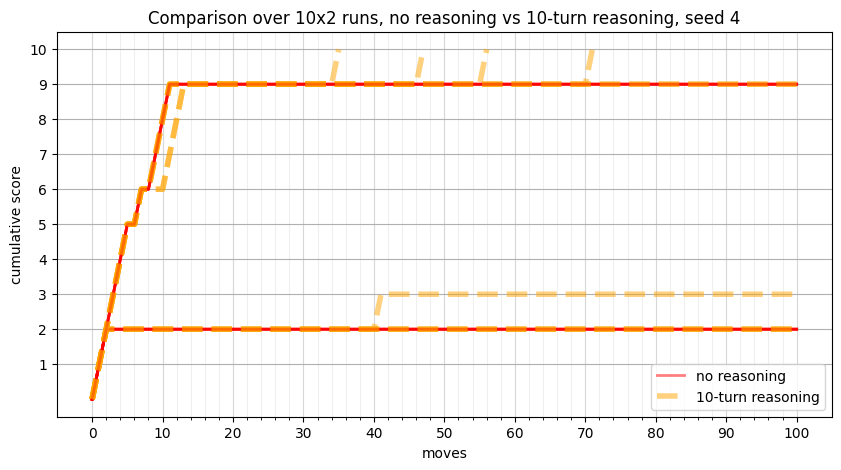

In [226]:
fig, ax = plt.subplots(figsize=(10,5))
moves = np.arange(0, max_steps+1, 1)

for i in range(n_episodes):
    if i == 0: # set labels just once
        ax.plot(moves[:len(cum_scores_nothink[i])], cum_scores_nothink[i], marker="", linestyle="-", linewidth=2, color="red", alpha=0.5, label="no reasoning")
        ax.plot(moves[:len(cum_scores_10think[i])], cum_scores_10think[i], marker="", linestyle="--", linewidth=4, color="orange", alpha=0.5, label = "10-turn reasoning")
    else:
        ax.plot(moves[:len(cum_scores_nothink[i])], cum_scores_nothink[i], marker="", linestyle="-", linewidth=2, color="red", alpha=0.5)
        ax.plot(moves[:len(cum_scores_10think[i])], cum_scores_10think[i], marker="", linestyle="--", linewidth=4, color="orange", alpha=0.5)


ax.set_title(f"Comparison over 10x2 runs, no reasoning vs 10-turn reasoning, seed {bundle_seed}")
ax.set_xlabel('moves')
ax.set_ylabel('cumulative score')

major_ticks = np.arange(0, max_steps+1, 10)
minor_ticks = np.arange(0, max_steps+1, 2)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(axis="x", which='minor', alpha=0.2)
ax.grid(axis="x", which='major', alpha=0.5)
# ax.minorticks_on()

ticks_y = np.arange(1, max_score_bundle+1, 1)
ax.set_yticks(ticks_y)
ax.grid(axis="y")


ax.legend()
plt.show()